# 不偏分散の分散と標本分散の平均二乗誤差

* 黒木玄
* 2022-01-24

$
\newcommand\var{\operatorname{var}}
$

$X_1, X_2, \ldots, X_n$ はその各々が分散 $\sigma^2$ と尖度 $\kappa$ (正規分布で0になるようにしたもの, kurtosis)を持つ分布に従う独立同分布確率変数達であるとする。このとき, その標本平均 $\bar{X}$, 不偏分散 $U$ と標本分散 $V$ が次のように定義される:

$$
\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i, \quad
U = \frac{1}{n-1}\sum_{i=1}^n (X_i - \bar{X})^2, \quad
V = \frac{1}{n}\sum_{i=1}^n (X_i - \bar{X})^2 = \frac{n-1}{n}U.
$$

このとき, $\var(\bar{X}) = E[(\bar{X}-\mu)^2] = {\sigma^2}/{n}$ でかつ, 

$$
E[U] = \sigma^2, \quad
\var(U) = \sigma^4\left(\frac{\kappa+3}{n} - \frac{n-3}{n(n-1)}\right), \quad
E\left[\left(V - \sigma^2\right)^2\right] = \left(\frac{n-1}{n}\right)^2 \var(U) + \frac{\sigma^4}{n^2}.
$$

ゆえに

$$
\var(U) - E\left[\left(V - \sigma^2\right)^2\right] =
\frac{\sigma^4}{n^2}
\left(\left(2 - \frac{1}{n}\right)(\kappa + 3) - \left(3 - \frac{5n-3}{n(n-1)}\right)\right).
$$

これより, $\kappa > -\dfrac{3}{2}$ ならば十分大きな $n$ について $\var(U) > E\left[\left(V - \sigma^2\right)^2\right]$.

正規分布の場合には $\kappa = 0$ となるので,

$$
\var(U) = \frac{2\sigma^4}{n-1}, \quad
\var(U) - E\left[\left(V - \sigma^2\right)^2\right] = \frac{(3n - 1)\sigma^4}{n^2(n-1)} > 0.
$$

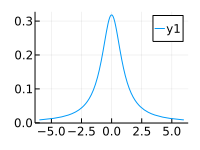

In [1]:
using Random
using Distributions
using StatsPlots
plot(TDist(1), -6, 6; size=(200, 150))

In [2]:
function diffvarvar(dist, n)
    σ = std(dist)
    μ₄ = kurtosis(dist) + 3
    σ^4/n^2 * ((2 - 1/n)*μ₄ - (3 - (5n-3)/(n*(n-1))))
end

function diffvarvarnormal(dist, n)
    σ = std(dist)
    (3n - 1)/(n^2*(n-1)) * σ^4
end

function var_unbiasedvar(dist, n)
    σ = std(dist)
    μ₄ = kurtosis(dist) + 3
    σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
end

function var_var(dist, n) # 正確には分散ではなく、σ²に対する平均二乗誤差
    σ = std(dist)
    ((n-1)/n)^2 * var_unbiasedvar(dist, n) + σ^4/n^2
end

function simvar(dist, n; L = 10^7)
    σ² = var(dist)
    tmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    V = Vector{Float64}(undef, L)
    U = similar(V)
    Threads.@threads for i in 1:L
        X = rand!(dist, tmp[Threads.threadid()])
        V[i] = var(X; corrected=false)
        U[i] = var(X)
    end
    varU = var(U; mean=σ²)
    varV = var(V; mean=σ²) 
    varU, varV, varU - varV, varV/varU, varU/varV, √(varU/varV)
end

simvar (generic function with 1 method)

In [3]:
dist = Normal()
n = 10
diffvarvarnormal(dist, n) |> display
simvar(dist, n; L = 10^8) |> display
var_unbiasedvar(dist, n), var_var(dist, n), diffvarvar(dist, n), var_var(dist, n)/var_unbiasedvar(dist, n), var_unbiasedvar(dist, n)/var_var(dist, n), √(var_unbiasedvar(dist, n)/var_var(dist, n))

0.03222222222222222

(0.22221164920855593, 0.18999102131327705, 0.03222062789527888, 0.8550002755929401, 1.1695902662797424, 1.0814759665751905)

(0.2222222222222222, 0.19, 0.032222222222222215, 0.8550000000000001, 1.1695906432748537, 1.0814761408717501)

In [4]:
dist = Normal(1, 2)
n = 10
diffvarvarnormal(dist, n) |> display
simvar(dist, n; L = 10^8) |> display
var_unbiasedvar(dist, n), var_var(dist, n), diffvarvar(dist, n), var_var(dist, n)/var_unbiasedvar(dist, n), var_unbiasedvar(dist, n)/var_var(dist, n), √(var_unbiasedvar(dist, n)/var_var(dist, n))

0.5155555555555555

(3.5559430999629327, 3.0402800115236226, 0.5156630884393101, 0.8549855624954501, 1.16961039328114, 1.0814852718743515)

(3.5555555555555554, 3.04, 0.5155555555555554, 0.8550000000000001, 1.1695906432748537, 1.0814761408717501)

In [5]:
dist = Exponential()
n = 10
simvar(dist, n; L = 10^8) |> display
var_unbiasedvar(dist, n), var_var(dist, n), diffvarvar(dist, n), var_var(dist, n)/var_unbiasedvar(dist, n), var_unbiasedvar(dist, n)/var_var(dist, n), √(var_unbiasedvar(dist, n)/var_var(dist, n))

(0.8218798971391963, 0.675742477097885, 0.14613742004131125, 0.8221912708292451, 1.2162620006795022, 1.1028426908129292)

(0.8222222222222222, 0.676, 0.1462222222222222, 0.8221621621621622, 1.2163050624589085, 1.1028622137234136)

In [6]:
dist = Exponential(2)
n = 10
simvar(dist, n; L = 10^8) |> display
var_unbiasedvar(dist, n), var_var(dist, n), diffvarvar(dist, n), var_var(dist, n)/var_unbiasedvar(dist, n), var_unbiasedvar(dist, n)/var_var(dist, n), √(var_unbiasedvar(dist, n)/var_var(dist, n))

(13.155278877341031, 10.815930991952643, 2.3393478853883884, 0.8221742079966288, 1.2162872421365234, 1.1028541345692655)

(13.155555555555555, 10.816, 2.339555555555555, 0.8221621621621622, 1.2163050624589085, 1.1028622137234136)

In [7]:
dist = Bernoulli(0.5)
n = 10
simvar(dist, n; L = 10^8) |> display
var_unbiasedvar(dist, n), var_var(dist, n), diffvarvar(dist, n), var_var(dist, n)/var_unbiasedvar(dist, n), var_unbiasedvar(dist, n)/var_var(dist, n), √(var_unbiasedvar(dist, n)/var_var(dist, n))

(0.0013887897126533299, 0.0017498248184982476, -0.0003610351058449177, 1.2599638394175228, 0.7936735711893897, 0.8908835901448571)

(0.0013888888888888892, 0.0017500000000000003, -0.0003611111111111112, 1.26, 0.7936507936507937, 0.890870806374748)

In [8]:
dist = Bernoulli(0.5)
n = 100
simvar(dist, n; L = 10^8) |> display
var_unbiasedvar(dist, n), var_var(dist, n), diffvarvar(dist, n), var_var(dist, n)/var_unbiasedvar(dist, n), var_unbiasedvar(dist, n)/var_var(dist, n), √(var_unbiasedvar(dist, n)/var_var(dist, n))

(1.2619728323524082e-5, 1.861847548238476e-5, -5.9987471588606795e-6, 1.475346774912625, 0.6778067482197353, 0.823290196844184)

(1.2626262626262599e-5, 1.8624999999999975e-5, -5.998737373737374e-6, 1.4751000000000012, 0.6779201410073887, 0.8233590595890645)

In [ ]:
dist = Bernoulli(0.5)
n = 1000
simvar(dist, n; L = 10^8) |> display
var_unbiasedvar(dist, n), var_var(dist, n), diffvarvar(dist, n), var_var(dist, n)/var_unbiasedvar(dist, n), var_unbiasedvar(dist, n)/var_var(dist, n), √(var_unbiasedvar(dist, n)/var_var(dist, n))

In [ ]:
dist = Bernoulli(0.4)
n = 10
simvar(dist, n; L = 10^8) |> display
var_unbiasedvar(dist, n), var_var(dist, n), diffvarvar(dist, n), var_var(dist, n)/var_unbiasedvar(dist, n), var_unbiasedvar(dist, n)/var_var(dist, n), √(var_unbiasedvar(dist, n)/var_var(dist, n))

In [ ]:
dist = Bernoulli(0.3)
n = 10
simvar(dist, n; L = 10^8) |> display
var_unbiasedvar(dist, n), var_var(dist, n), diffvarvar(dist, n), var_var(dist, n)/var_unbiasedvar(dist, n), var_unbiasedvar(dist, n)/var_var(dist, n), √(var_unbiasedvar(dist, n)/var_var(dist, n))

In [ ]:
dist = Bernoulli(0.2)
n = 10
simvar(dist, n; L = 10^8) |> display
var_unbiasedvar(dist, n), var_var(dist, n), diffvarvar(dist, n), var_var(dist, n)/var_unbiasedvar(dist, n), var_unbiasedvar(dist, n)/var_var(dist, n), √(var_unbiasedvar(dist, n)/var_var(dist, n))

In [ ]:
using SymPy
@vars σ μ₄ n

σ = 1
μ₄ = 0
vu = σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
vv =  ((n-1)/n)^2 * vu + σ^4/n^2
[vu, vv] .|> simplify .|> factor

In [ ]:
(vu - vv)*(-n^2) |> simplify

In [ ]:
@vars σ μ₄ n

μ₄ = 3 # normal dist. case
vu = σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
vv =  ((n-1)/n)^2 * vu + σ^4/n^2
[vu, vv, vv/vu] .|> simplify .|> factor

In [ ]:
@vars σ μ₄ n

μ₄ = 3 # normal dist. case
vu = σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
vv =  ((n-1)/n)^2 * vu + σ^4/n^2
F = vv/vu |> simplify |> factor
F(n => 10)

In [ ]:
@vars σ μ₄ n

μ₄ = 1 # Bernoulli(1/2)
vu = σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
vv =  ((n-1)/n)^2 * vu + σ^4/n^2
F = vv/vu |> simplify |> factor

In [ ]:
F(n => 10)

In [ ]:
@vars σ μ₄ n

μ₄ = 3//2
vu = σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
vv =  ((n-1)/n)^2 * vu + σ^4/n^2
F = vv/vu |> simplify |> factor

In [ ]:
@vars σ μ₄ n

μ₄ = 0
vu = σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
vv =  ((n-1)/n)^2 * vu + σ^4/n^2
F = vv/vu |> simplify |> factor

In [ ]:
@vars σ μ₄ n

μ₄ = 1//2
vu = σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
vv =  ((n-1)/n)^2 * vu + σ^4/n^2
F = vv/vu |> simplify |> factor

In [ ]:
@vars σ μ₄ n

μ₄ = 1
vu = σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
vv =  ((n-1)/n)^2 * vu + σ^4/n^2
F = vv/vu |> simplify |> factor

In [ ]:
@vars σ μ₄ n

μ₄ = 3//2
vu = σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
vv =  ((n-1)/n)^2 * vu + σ^4/n^2
F = vv/vu |> simplify |> factor

In [ ]:
@vars σ μ₄ n

μ₄ = 2
vu = σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
vv =  ((n-1)/n)^2 * vu + σ^4/n^2
F = vv/vu |> simplify |> factor

In [ ]:
@vars σ μ₄ n

μ₄ = 5//2
vu = σ^4 * (μ₄/n - (n-3)/(n*(n-1)))
vv =  ((n-1)/n)^2 * vu + σ^4/n^2
F = vv/vu |> simplify |> factor

In [ ]:
skewness(Normal()), skewness(Gamma(20, 1)), skewness(InverseGamma(20, 1))

In [ ]:
kurtosis(Normal()), kurtosis(Gamma(20, 1)), kurtosis(InverseGamma(20, 1)), kurtosis(Laplace())

In [ ]:
kurtosis(TDist(4.0001)), kurtosis(TDist(10)), kurtosis(TDist(20))

In [ ]:
skewness(Beta(0.1, 9.9)), skewness(Beta(7, 3)), skewness(Beta(7, 3)), skewness(Beta(9.9, 0.1))

In [ ]:
kurtosis(Beta(0.1, 9.9)), kurtosis(Beta(7, 3)), kurtosis(Beta(7, 3)), kurtosis(Beta(9.9, 0.1))

In [ ]:
kurtosis.(Bernoulli.(0.1:0.1:0.9))

In [ ]:
Binomial.(100, [0.01, 0.3, 0.7, 0.99]) .|> skewness

In [ ]:
Binomial.(100, [0.01, 0.3, 0.7, 0.99]) .|> kurtosis